In [12]:
import utils
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,Add, ReLU, Input
from keras.regularizers import L1, L2, L1L2
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [13]:
# Load the Dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


(2115, 22, 1000)


In [14]:
ind_valid = np.random.choice(2115, 200, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Shuffle the data after adding the noise to them so that the noisy examples 
# are not all together
x_train, y_train = utils.addNoisyExamplesToData(x_train, y_train, 6000, 0, 1)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
print(x_train.shape)
print(y_train.shape)

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

# Reshape so that each example is three-dimensional 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Axis swapping
x_train = np.swapaxes(x_train, 1, 3)
x_train = np.swapaxes(x_train, 1, 2)
x_valid = np.swapaxes(x_valid, 1, 3)
x_valid = np.swapaxes(x_valid, 1, 2)
X_test = np.swapaxes(X_test, 1, 3)
X_test = np.swapaxes(X_test, 1, 2)

x_train = x_train[:, 0:600, :, :]
x_valid = x_valid[:, 0:600, :, :]
X_test = X_test[:, 0:600, :, :]

print(x_train.shape)

(7915, 22, 1000)
(7915,)
(7915, 600, 1, 22)


# Approach 3: Residual Network
The previous architecture, while performing fairly decently, could do better by going deeper. As discussed in class, deeper architectures often face the issues of vanishing gradients - if these issues are overcome, then it is likely that the model can improve. One way to do so is to leverage residual layers, which provide a gradient "highway" to ensure that gradients do not vanish as they go deeper.

In [117]:
def ResidualBlock(input, filters, kernel):
  cnv = Conv2D(filters=filters, kernel_size=kernel, activation='relu', padding='same')(input)
  cnv = BatchNormalization()(cnv)
  cnv = Dropout(0.4)(cnv)
  cnv = Conv2D(filters=filters, kernel_size=kernel, activation='relu', padding='same')(cnv)
  cnv = BatchNormalization()(cnv)
  cnv = Dropout(0.4)(cnv)
  output = Add()([input, cnv])
  output = ReLU()(output)
  output = BatchNormalization()(output)
  output = Dropout(0.4)(output)
  return output

In [138]:

ipt = Input((600, 1, 22))

outputs = Conv2D(filters=15, kernel_size=(1, 1), activation='relu', padding='same')(ipt)
outputs = MaxPooling2D(pool_size=(3, 1), padding="same")(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.5)(outputs)

outputs = ResidualBlock(outputs, filters=15, kernel=(15, 1))

outputs = ResidualBlock(outputs, filters=15, kernel=(15, 1))




outputs = Flatten()(outputs)
outputs = Dense(4, activation='softmax')(outputs)

model = Model(inputs=ipt, outputs=outputs, name="ResidualNetwork")
model.summary()



Model: "ResidualNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 600, 1, 22)]         0         []                            
                                                                                                  
 conv2d_314 (Conv2D)         (None, 600, 1, 15)           345       ['input_37[0][0]']            
                                                                                                  
 max_pooling2d_107 (MaxPool  (None, 200, 1, 15)           0         ['conv2d_314[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 batch_normalization_410 (B  (None, 200, 1, 15)           60        ['max_pooling2d_

In [139]:
learning_rate = 1e-3
epochs = 150
cnn_model_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [140]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/150
124/124 [==============================] - 4s 26ms/step - loss: 1.9399 - accuracy: 0.2953 - val_loss: 1.4123 - val_accuracy: 0.3800
Epoch 2/150
124/124 [==============================] - 3s 25ms/step - loss: 1.5106 - accuracy: 0.3732 - val_loss: 1.3123 - val_accuracy: 0.4000
Epoch 3/150
124/124 [==============================] - 3s 24ms/step - loss: 1.3431 - accuracy: 0.4181 - val_loss: 1.2847 - val_accuracy: 0.3800
Epoch 4/150
124/124 [==============================] - 3s 26ms/step - loss: 1.2337 - accuracy: 0.4648 - val_loss: 1.2630 - val_accuracy: 0.3800
Epoch 5/150
124/124 [==============================] - 3s 25ms/step - loss: 1.1902 - accuracy: 0.4822 - val_loss: 1.2216 - val_accuracy: 0.4500
Epoch 6/150
124/124 [==============================] - 3s 25ms/step - loss: 1.1334 - accuracy: 0.5171 - val_loss: 1.1553 - val_accuracy: 0.4850
Epoch 7/150
124/124 [==============================] - 3s 26ms/step - loss: 1.0692 - accuracy: 0.5525 - val_loss: 1.1731 - val_accuracy:

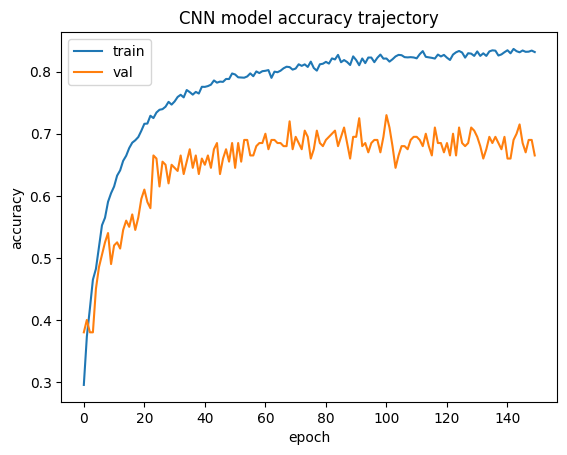

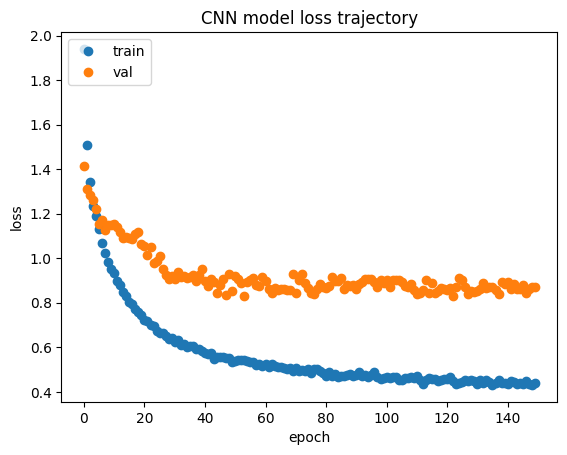

In [141]:
# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [142]:
cnn_model_score_all_subjects = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy Across All Subjects: {score}".format(score=cnn_model_score_all_subjects[1]))

Accuracy Across All Subjects: 0.715575635433197


In [143]:
# Test the model against each individual subject group
for i in range(9):
  indices = np.where(person_test[:, 0] == i)
  x = X_test[indices]
  y = y_test[indices]
  score = model.evaluate(x, y, verbose=0)
  print("Subject {subject} Accuracy: {score}".format(subject=i, score=score[1]))

Subject 0 Accuracy: 0.5799999833106995
Subject 1 Accuracy: 0.5600000023841858
Subject 2 Accuracy: 0.8399999737739563
Subject 3 Accuracy: 0.7599999904632568
Subject 4 Accuracy: 0.7446808218955994
Subject 5 Accuracy: 0.6326530575752258
Subject 6 Accuracy: 0.7200000286102295
Subject 7 Accuracy: 0.8199999928474426
Subject 8 Accuracy: 0.7872340679168701
